In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
import findspark
findspark.init()

spark-2.4.0-bin-hadoop2.7/
spark-2.4.0-bin-hadoop2.7/python/
spark-2.4.0-bin-hadoop2.7/python/setup.cfg
spark-2.4.0-bin-hadoop2.7/python/pyspark/
spark-2.4.0-bin-hadoop2.7/python/pyspark/resultiterable.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/pyspark/
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/pyspark/shell.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/heapq3.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/join.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/version.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/rdd.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/java_gateway.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/find_spark_home.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/_globals.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/worker.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/mllib/
spark-2.4.0-bin-hadoop2.7/python/pyspark/mllib/feature.py
spark-2.4.0-bin-hadoop2.7/python/pyspark

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/My Drive/LDS9_K273_ONLINE_BuiThiHuong/Chapter9/'

/content/gdrive/My Drive/LDS9_K273_ONLINE_BuiThiHuong/Chapter9


# Demo KMeans Clustering

In [4]:
import pyspark

In [5]:
from pyspark.sql import SparkSession

In [62]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark.sql.functions as f

In [6]:
spark = SparkSession.builder.appName('kmeans_demo').getOrCreate()

In [7]:
# Loads data.
data = spark.read.csv("5000_points.txt", header=False,
                      inferSchema=True, sep="\t")

In [8]:
data.show(3)

+------+------+
|   _c0|   _c1|
+------+------+
|664159|550946|
|665845|557965|
|597173|575538|
+------+------+
only showing top 3 rows



In [9]:
from pyspark.sql.functions import col
data = data.select(col("_c0").alias("x"), col("_c1").alias("y"))

In [10]:
data.show(3)

+------+------+
|     x|     y|
+------+------+
|664159|550946|
|665845|557965|
|597173|575538|
+------+------+
only showing top 3 rows



In [12]:
data.columns

['x', 'y']

## Vector Assembler

In [13]:
vec_assembler = VectorAssembler(inputCols=data.columns,
                                outputCol='features')

In [14]:
final_data = vec_assembler.transform(data)

In [15]:
final_data.show(5)

+------+------+-------------------+
|     x|     y|           features|
+------+------+-------------------+
|664159|550946|[664159.0,550946.0]|
|665845|557965|[665845.0,557965.0]|
|597173|575538|[597173.0,575538.0]|
|618600|551446|[618600.0,551446.0]|
|635690|608046|[635690.0,608046.0]|
+------+------+-------------------+
only showing top 5 rows



## Scaling

In [17]:
scaler = StandardScaler(inputCol='features',
                        outputCol='scaledFeatures',
                        withStd=True,
                        withMean=False)

In [18]:
# compute summary statistics by fitting the StandardScaler
scaler_model = scaler.fit(final_data)

In [19]:
# normalize each feature to have unit standard deviation
final_data = scaler_model.transform(final_data)

In [21]:
final_data.show(3,False)

+------+------+-------------------+---------------------------------------+
|x     |y     |features           |scaledFeatures                         |
+------+------+-------------------+---------------------------------------+
|664159|550946|[664159.0,550946.0]|[2.716775610700365,2.336092297255214]  |
|665845|557965|[665845.0,557965.0]|[2.7236722780340017,2.3658538924649704]|
|597173|575538|[597173.0,575538.0]|[2.4427660270639544,2.440366004250274] |
+------+------+-------------------+---------------------------------------+
only showing top 3 rows



## Build model

In [23]:
# trains a k-means model
k_list = []
wsse_list = []
silhouette_list = []

wsse_str= ""
sil_str = ""

for k in range(2,11):    
    kmeans = KMeans(featuresCol='scaledFeatures',k=k)
    model = kmeans.fit(final_data)
    # wsse
    wsse = model.computeCost(final_data)
    k_list.append(k)
    wsse_list.append(wsse) 
    
    # silhoutte
    predictions = model.transform(final_data)
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_list.append(silhouette)
    
    wsse_str = wsse_str + "With k =" + str(k) + "- Set Sum of Squared Errors = " + str(wsse) + "\n"
    sil_str = sil_str + "With k =" + str(k) + "- Silhouette = " + str(silhouette) + "\n"

In [29]:
print(wsse_str)

With k =2- Set Sum of Squared Errors = 6378.971476210267
With k =3- Set Sum of Squared Errors = 3706.74238791025
With k =4- Set Sum of Squared Errors = 2406.331723769621
With k =5- Set Sum of Squared Errors = 2114.164524170404
With k =6- Set Sum of Squared Errors = 1431.664009603456
With k =7- Set Sum of Squared Errors = 1104.0125076510647
With k =8- Set Sum of Squared Errors = 1049.806926503623
With k =9- Set Sum of Squared Errors = 705.6686826156156
With k =10- Set Sum of Squared Errors = 620.1750606348105



In [25]:
sil_str

'With k =2- Silhouette = 0.4905230801652404\nWith k =3- Silhouette = 0.5792476589423854\nWith k =4- Silhouette = 0.614662491276157\nWith k =5- Silhouette = 0.5639991546126766\nWith k =6- Silhouette = 0.6568238335643326\nWith k =7- Silhouette = 0.6798678060703472\nWith k =8- Silhouette = 0.6449975066568482\nWith k =9- Silhouette = 0.7381227332089734\nWith k =10- Silhouette = 0.7508594626917908\n'

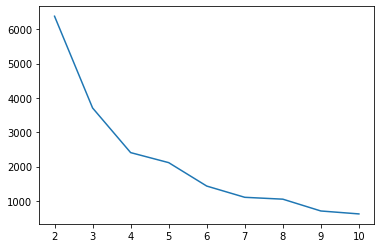

In [28]:
plt.plot(k_list, wsse_list)
plt.show()

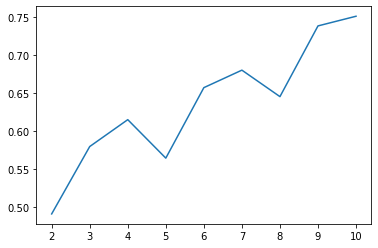

In [30]:
plt.plot(k_list, silhouette_list)
plt.show()

## Build model

In [40]:
# train a k-mean model
kmeans = KMeans(featuresCol='scaledFeatures', k=10)
model = kmeans.fit(final_data)

In [41]:
# evaluate clustering by computing within set sum of squared errors
wsse = model.computeCost(final_data)
print(wsse)

620.1750606348105


In [42]:
# silhouette
predictions = model.transform(final_data)
# evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(silhouette)

0.7508594626917908


In [44]:
# show the result
centers = model.clusterCenters()
for center in centers:
  print(center)

[2.50450043 2.03880019]
[1.37959838 2.38348604]
[2.77092183 3.63555263]
[0.57020316 2.36661263]
[1.63626698 1.71503364]
[1.33679274 3.4704405 ]
[3.44746743 2.66547387]
[1.70474147 0.71409081]
[0.68988697 1.46808503]
[3.38465688 1.00825149]


## Prediction

In [45]:
predictions = model.transform(final_data)

In [46]:
predictions.select('prediction').show(5)

+----------+
|prediction|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
+----------+
only showing top 5 rows



In [49]:
predictions.groupBy('prediction').count().orderBy('count').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  329|
|         8|  338|
|         3|  345|
|         4|  354|
|         2|  380|
|         0|  624|
|         9|  642|
|         6|  649|
|         5|  652|
|         7|  687|
+----------+-----+



=> Nếu nhóm nào quá nhỏ thì hoặc là kim cương hoặc là rác. Còn thông thường các nhóm phải đều nhau

In [53]:
final_data.show(5,False)

+------+------+-------------------+---------------------------------------+
|x     |y     |features           |scaledFeatures                         |
+------+------+-------------------+---------------------------------------+
|664159|550946|[664159.0,550946.0]|[2.716775610700365,2.336092297255214]  |
|665845|557965|[665845.0,557965.0]|[2.7236722780340017,2.3658538924649704]|
|597173|575538|[597173.0,575538.0]|[2.4427660270639544,2.440366004250274] |
|618600|551446|[618600.0,551446.0]|[2.5304142423414357,2.3382123709986073]|
|635690|608046|[635690.0,608046.0]|[2.6003217421823916,2.5782047187507375]|
+------+------+-------------------+---------------------------------------+
only showing top 5 rows



In [51]:
temp = final_data.select("scaledFeatures").rdd.map(lambda x: x[0].toArray().tolist()).toDF()

In [52]:
temp.show(5)

+------------------+------------------+
|                _1|                _2|
+------------------+------------------+
| 2.716775610700365| 2.336092297255214|
|2.7236722780340017|2.3658538924649704|
|2.4427660270639544| 2.440366004250274|
|2.5304142423414357|2.3382123709986073|
|2.6003217421823916|2.5782047187507375|
+------------------+------------------+
only showing top 5 rows



In [58]:
data_result = predictions.select('prediction')
data_result.columns

['prediction']

In [60]:
# since there is no common column between these two dataframes add row_index so that it can be joined
temp=temp.withColumn('row_index', f.monotonically_increasing_id())
data_result=data_result.withColumn('row_index', f.monotonically_increasing_id())
temp = temp.join(data_result, on=["row_index"]).sort("row_index").drop("row_index")

In [61]:
temp.show(5)

+------------------+------------------+----------+
|                _1|                _2|prediction|
+------------------+------------------+----------+
| 2.716775610700365| 2.336092297255214|         0|
|2.7236722780340017|2.3658538924649704|         0|
|2.4427660270639544| 2.440366004250274|         0|
|2.5304142423414357|2.3382123709986073|         0|
|2.6003217421823916|2.5782047187507375|         0|
+------------------+------------------+----------+
only showing top 5 rows



In [63]:
temp = temp.select(col('_1').alias('x_scale'), col('_2').alias('y_scale'), 'prediction')

In [64]:
df = temp.toPandas()

In [65]:
centers_df = pd.DataFrame(centers)
centers_df.head()

,0,1
0,2.504500,2.038800
1,1.379598,2.383486
2,2.770922,3.635553
3,0.570203,2.366613
4,1.636267,1.715034


In [ ]:
# # rename if necessary
# centers_df = center_df.rename(columns={0: 'x_center', 1: 'y_center'})

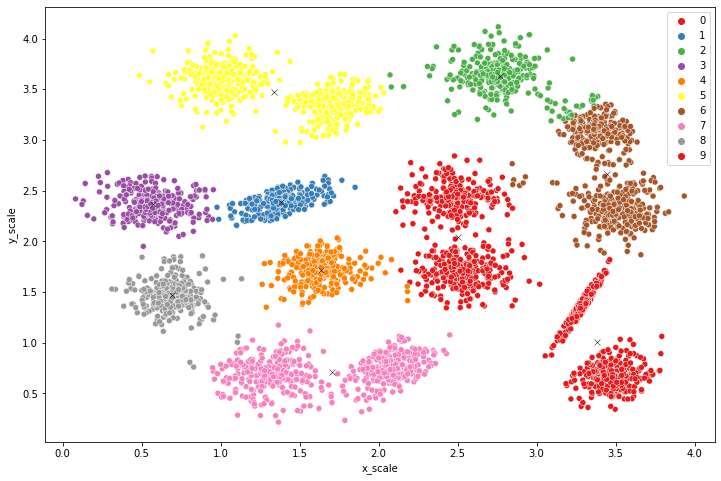

In [66]:
plt.figure(figsize=(12,8))
sns.scatterplot(x="x_scale", y="y_scale", data = df, 
                hue="prediction", 
                # size = "prediction",
                palette="Set1")
sns.scatterplot(data = centers_df, x=0, y=1, color="black", marker="x")
plt.show()

In [67]:
# since there is no common column between these two dataframes add row_index so that it can be joined
final_data=final_data.withColumn('row_index', f.monotonically_increasing_id())
temp=temp.withColumn('row_index', f.monotonically_increasing_id())
final_data = final_data.join(temp, on=["row_index"]).sort("row_index").drop("row_index")


In [68]:
final_data.show(5)

+------+------+-------------------+--------------------+------------------+------------------+----------+
|     x|     y|           features|      scaledFeatures|           x_scale|           y_scale|prediction|
+------+------+-------------------+--------------------+------------------+------------------+----------+
|664159|550946|[664159.0,550946.0]|[2.71677561070036...| 2.716775610700365| 2.336092297255214|         0|
|665845|557965|[665845.0,557965.0]|[2.72367227803400...|2.7236722780340017|2.3658538924649704|         0|
|597173|575538|[597173.0,575538.0]|[2.44276602706395...|2.4427660270639544| 2.440366004250274|         0|
|618600|551446|[618600.0,551446.0]|[2.53041424234143...|2.5304142423414357|2.3382123709986073|         0|
|635690|608046|[635690.0,608046.0]|[2.60032174218239...|2.6003217421823916|2.5782047187507375|         0|
+------+------+-------------------+--------------------+------------------+------------------+----------+
only showing top 5 rows

